In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

from models.unet import Unet

import matplotlib.pyplot as plt
import numpy as np

## Set up

In [18]:
class CFG:
    # dataset
    batch_size = 4
    
    # noise
    B_0 = 1e-4
    B_T = 2e-2
    T = 500
    schedule_type = 'cosine'
    s = 0.008

## Dataset

In [19]:
from torch.utils.data import DataLoader
from data.dataset import CIFAR10_Dataset, MNIST_Dataset

batch_size = CFG.batch_size
train = CIFAR10_Dataset()
train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)

Files already downloaded and verified


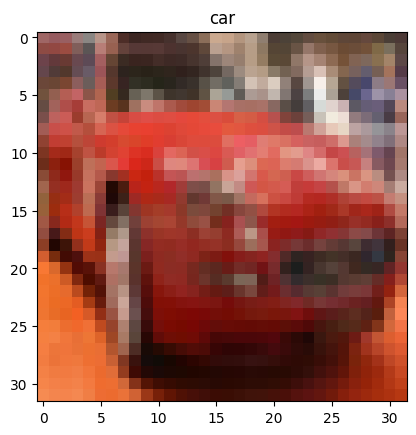

In [20]:
from utils.utils import show_image

image, labels = train[5]
show_image(image, train.classes[labels])

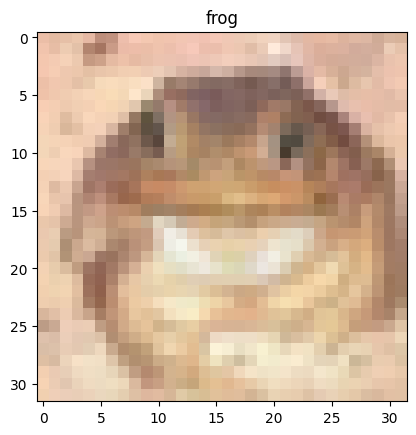

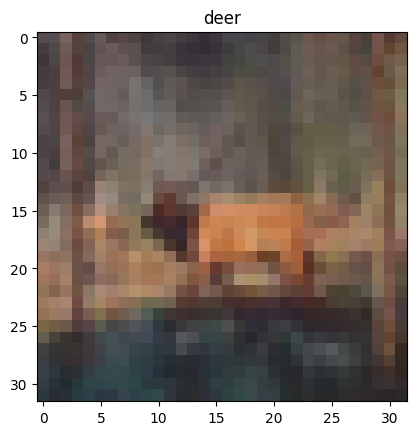

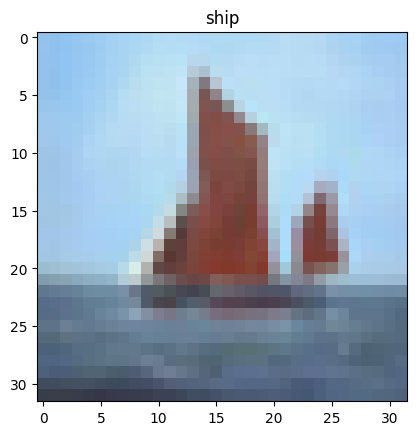

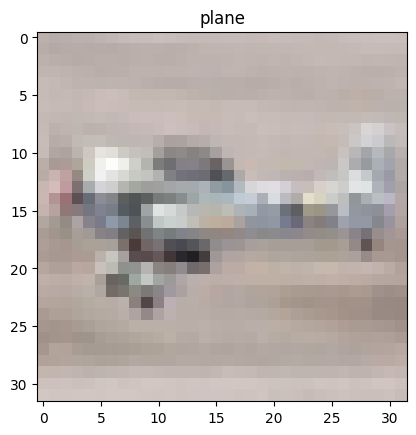

In [21]:
images, labels = next(iter(train_loader))
for image, labels in zip(images, labels):
    show_image(image, train.classes[labels])

## Noise

### Cosine Noise adder

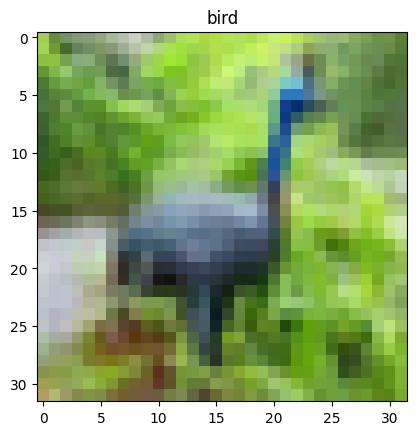

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


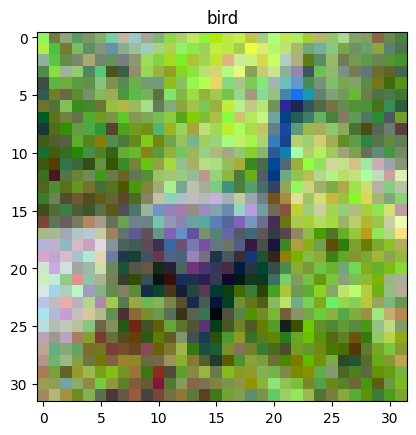

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


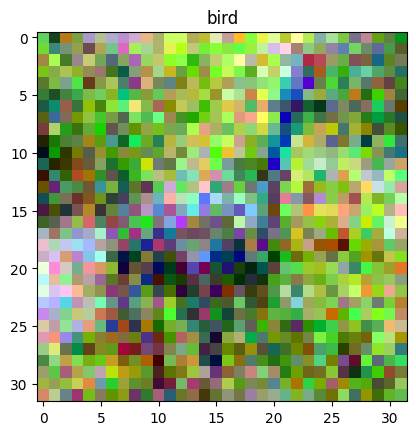

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


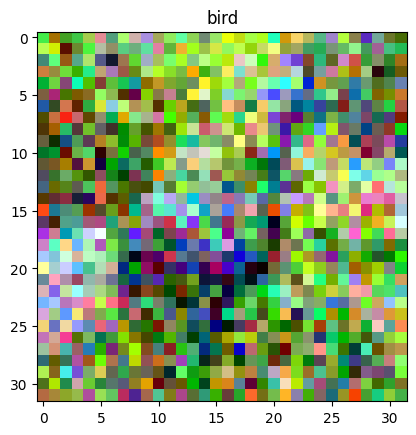

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


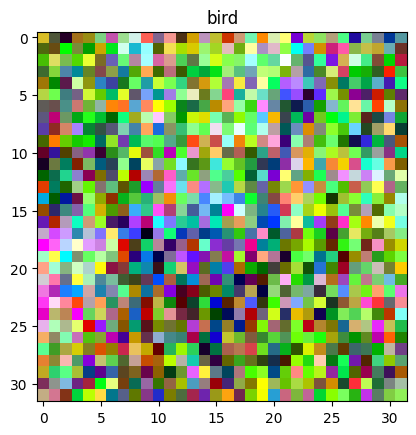

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


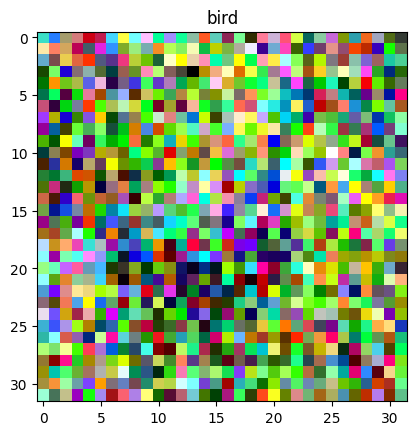

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


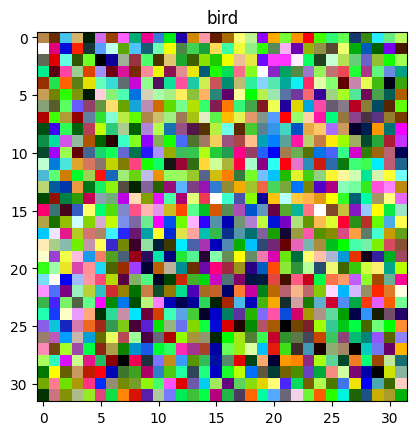

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


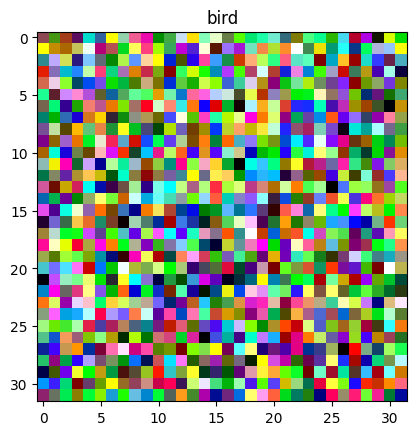

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


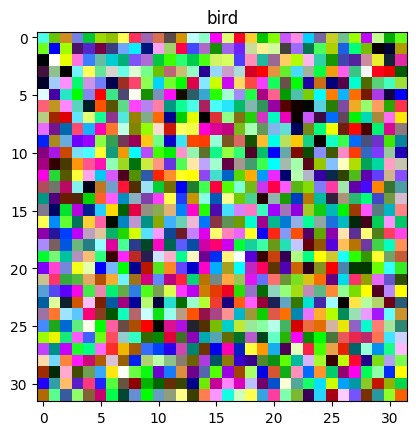

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


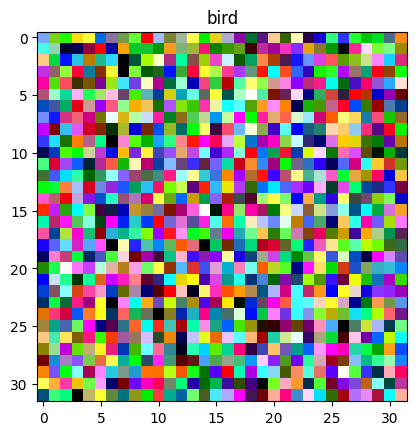

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


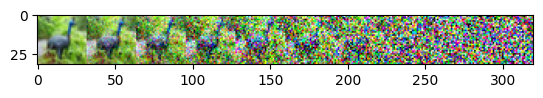

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


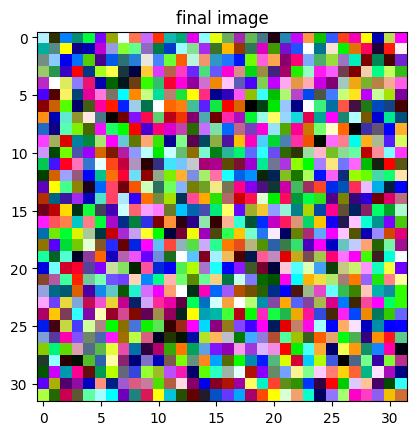

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


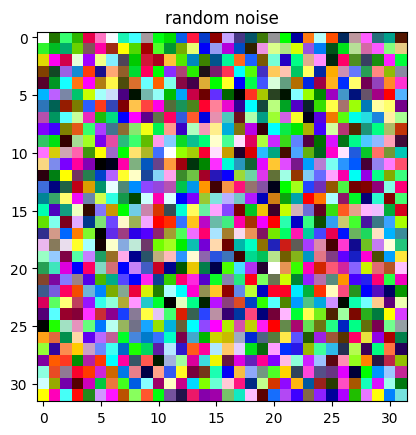

In [22]:
from utils.noise import CosineNoiseAdder

noise_adder = CosineNoiseAdder(CFG.T, CFG.s)

# Example input image
img, labels = train[6]
full_img = torch.tensor([])

# Visualize the noise addition process
for time_steps in torch.arange(0, CFG.T, 50):
    noisy_imgs, noises = noise_adder.image_at_time_step(img, time_steps)
    full_img = torch.cat((full_img, noisy_imgs), 2)
    show_image(noisy_imgs, train.classes[labels])
show_image(full_img)

final_noisy_img, noises = noise_adder.image_at_time_step(img, CFG.T - 1)
show_image(final_noisy_img, title="final image")

final_noise = torch.randn_like(img)
show_image(final_noise, title="random noise")

## Unet Model

In [23]:
train = CIFAR10_Dataset()
train_loader = DataLoader(train, shuffle=True, batch_size=16)
batch = next(iter(train_loader))
print(batch[0].shape)
# img, label = train[6]
imgs = batch[0]

# fake data for testing
# imgs = torch.randn(16, 3, 128, 128)

Files already downloaded and verified
torch.Size([16, 3, 32, 32])


In [24]:
torch.tensor([34] * 8).shape

torch.Size([8])

In [25]:
net = Unet(16, 3, 8, initial_channels=3)
print("\n", net(imgs, torch.tensor([34])).shape)


 torch.Size([16, 3, 32, 32])


## Noise Dataset

In [26]:
class NoiseDataset():
    def __init__(self, imgs_dataset, noise_schedule = None):
        self.imgs_dataset = imgs_dataset
        self.noise_schedule = noise_schedule if noise_schedule else CosineNoiseAdder()       

    def __getitem__(self, idx):
        img, label = self.imgs_dataset[idx]
        t = torch.randint(self.noise_schedule.T, (1, )).squeeze()
        # print(t)
        # t = 30
        noisy_img, noise = self.noise_schedule.image_at_time_step(img, t)
        return noisy_img, noise, t, label

    def __len__(self):
        return len(self.imgs_dataset)

## Training

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 32, 32]) torch.Size([16, 3, 32, 32]) torch.Size([16]) torch.Size([16])
start with shape torch.Size([16, 3, 32, 32])
label shape : torch.Size([16])
label_embeddings shape : torch.Size([16, 8])
label_embeddings shape : torch.Size([16, 8, 1, 1])
label_embeddings shape : torch.Size([16, 8, 32, 32])
after concatenating the timestep embedds : torch.Size([16, 19, 32, 32])
down block 0, with shape torch.Size([16, 19, 32, 32])
down block 1, with shape torch.Size([16, 16, 16, 16])
after bottleneck : shape = torch.Size([16, 32, 16, 16])
up block 0, with shape torch.Size([16, 32, 16, 16]), and skip shape : torch.Size([16, 32, 16, 16])
after final : shape = torch.Size([16, 3, 32, 32])

 torch.Size([16, 3, 32, 32])


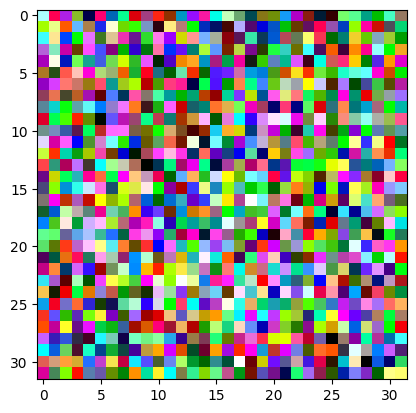

In [27]:
max_time_steps = 1000
batch_size = 16

CosineNoise = CosineNoiseAdder(max_time_steps)

# train = NoiseDataset(MNIST_Dataset(), CosineNoise)
# test = NoiseDataset(MNIST_Dataset('test'), CosineNoise)

train = NoiseDataset(CIFAR10_Dataset(), CosineNoise)
test = NoiseDataset(CIFAR10_Dataset('test'), CosineNoise)

train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test, shuffle=False, batch_size=batch_size)

net = Unet(16, depth=2, time_embed_dim=8, label_emb_dim=8, num_label=10, initial_channels=3, conv_layers=1)


noisy_imgs, noises, time_steps, labels = next(iter(train_loader))
print(noisy_imgs.shape, noises.shape, time_steps.shape, labels.shape)

print("\n", net(noisy_imgs, time_steps, labels, verbose=1).shape)
show_image(noisy_imgs[0])

### Weight Initialization

In [28]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


### Eval

In [29]:
def eval_model(model:nn.Module, criterion, device):
    model.eval()
    with torch.no_grad():
        for i, (noisy_imgs, noises, time_steps, labels) in enumerate(test_loader):
            noisy_imgs, noises, time_steps, labels = noisy_imgs.to(device), noises.to(device), time_steps.to(device), labels.to(device)
            outputs = model(noisy_imgs, time_steps, labels)
            loss = criterion(outputs, noises)
            # print(f"Batch {i}, Loss: {loss.item()}")
            return loss.item()

### Training Loop

Using device: cuda
Epoch [1/5], step(0/3125), Loss: 1.3544, Val Loss: 1.7665, lr: 0.01
Epoch [1/5], step(100/3125), Loss: 0.2792, Val Loss: 0.2821, lr: 0.01
Epoch [1/5], step(200/3125), Loss: 0.3048, Val Loss: 0.2659, lr: 0.01
Epoch [1/5], step(300/3125), Loss: 0.2248, Val Loss: 0.1965, lr: 0.01
Epoch [1/5], step(400/3125), Loss: 0.2399, Val Loss: 0.2650, lr: 0.01
Epoch [1/5], step(500/3125), Loss: 0.2641, Val Loss: 0.2652, lr: 0.01
Epoch [1/5], step(600/3125), Loss: 0.2383, Val Loss: 0.2340, lr: 0.01
Epoch [1/5], step(700/3125), Loss: 0.2731, Val Loss: 0.2939, lr: 0.01
Epoch [1/5], step(800/3125), Loss: 0.2516, Val Loss: 0.2615, lr: 0.01
Epoch [1/5], step(900/3125), Loss: 0.2331, Val Loss: 0.2527, lr: 0.01
Epoch [1/5], step(1000/3125), Loss: 0.2854, Val Loss: 0.3246, lr: 0.01
Epoch [1/5], step(1100/3125), Loss: 0.2908, Val Loss: 0.2399, lr: 0.01
Epoch [1/5], step(1200/3125), Loss: 0.2206, Val Loss: 0.2101, lr: 0.01
Epoch [1/5], step(1300/3125), Loss: 0.2104, Val Loss: 0.2334, lr: 0.01

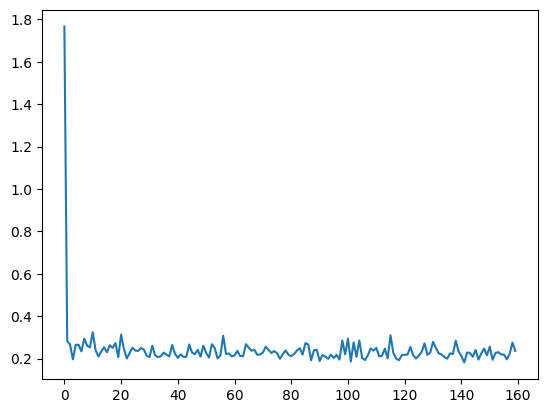

In [ ]:
# hyperparameters
n_epochs = 5
batch_size = 16
lr = 1e-2
max_time_steps = 1000
eval_every = 100

# model creation
net = Unet(32, depth=3, time_embed_dim=8, label_emb_dim=8, num_label=10, initial_channels=3, conv_layers=2)
net.apply(init_weights)

# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1,  gamma=0.316)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs * len(train_loader), eta_min=1e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50, min_lr=1e-4)

# dataset creation
# CIFAR10 = CIFAR10_Dataset()
# CosineNoise = CosineNoiseAdder(max_time_steps)
# train = NoiseDataset(CIFAR10, CosineNoise)
# train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
net.to(device)

# keep track of the loss
train_losses = []
val_losses = []
best_loss = np.inf
best_loss_i = 0
# training loop
for epoch in range(n_epochs):
    for i, batch in enumerate(train_loader):
        noisy_imgs, noises, time_steps, labels = batch
        noisy_imgs, noises, time_steps, labels = noisy_imgs.to(device), noises.to(device), time_steps.to(device), labels.to(device)
        # print(noisy_imgs.shape, noises.shape, time_steps.shape, labels.shape)
        
        optimizer.zero_grad()
        
        predicted_noise = net(noisy_imgs, time_steps, labels)
        loss = criterion(predicted_noise, noises)
        
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_loss_i = epoch * len(train_loader) + i
            torch.save(net.state_dict(), 'best_model_CIFAR.pth')
        train_losses.append(loss.item())
        
        # if epoch * len(train_loader) + i - best_loss_i > 1000:
        #     print("Stopping early")
        #     break
        
        if i%eval_every == 0:
            val_loss = eval_model(net, criterion, device)
            val_losses.append(val_loss)
            # scheduler.step(val_loss)
            print(f'Epoch [{epoch+1}/{n_epochs}], step({i}/{len(train_loader)}), Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, lr: {scheduler.get_last_lr()[0]}')
            # print(f'Epoch [{epoch+1}/{n_epochs}], step({i}/{len(train_loader)}), Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

        
        
        # show_image(noisy_imgs[0], title="noisy image")
        # show_image(predicted_noise[0], title="predicted noise")
        
        # break
    if epoch < 5:
        scheduler.step()
    # break
    
plt.plot(val_losses)


In [ ]:
net.load_state_dict(torch.load('best_model_CIFAR.pth'))

RuntimeError: Error(s) in loading state_dict for Unet:
	Missing key(s) in state_dict: "label_emb.weight", "down_blocks.2.convs.0.weight", "down_blocks.2.convs.0.bias", "down_blocks.2.convs.1.weight", "down_blocks.2.convs.1.bias", "down_blocks.2.norms.0.weight", "down_blocks.2.norms.0.bias", "down_blocks.2.norms.0.running_mean", "down_blocks.2.norms.0.running_var", "down_blocks.2.norms.1.weight", "down_blocks.2.norms.1.bias", "down_blocks.2.norms.1.running_mean", "down_blocks.2.norms.1.running_var", "up_blocks.1.convs.0.weight", "up_blocks.1.convs.0.bias", "up_blocks.1.convs.1.weight", "up_blocks.1.convs.1.bias", "up_blocks.1.norms.0.weight", "up_blocks.1.norms.0.bias", "up_blocks.1.norms.0.running_mean", "up_blocks.1.norms.0.running_var", "up_blocks.1.norms.1.weight", "up_blocks.1.norms.1.bias", "up_blocks.1.norms.1.running_mean", "up_blocks.1.norms.1.running_var", "up_blocks.1.up_conv.weight", "up_blocks.1.up_conv.bias". 
	size mismatch for down_blocks.0.convs.0.weight: copying a param with shape torch.Size([16, 9, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 19, 3, 3]).
	size mismatch for down_blocks.0.convs.0.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for down_blocks.0.convs.1.weight: copying a param with shape torch.Size([16, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for down_blocks.0.convs.1.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for down_blocks.0.norms.0.weight: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for down_blocks.0.norms.0.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for down_blocks.0.norms.0.running_mean: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for down_blocks.0.norms.0.running_var: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for down_blocks.0.norms.1.weight: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for down_blocks.0.norms.1.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for down_blocks.0.norms.1.running_mean: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for down_blocks.0.norms.1.running_var: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for down_blocks.1.convs.0.weight: copying a param with shape torch.Size([32, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 32, 3, 3]).
	size mismatch for down_blocks.1.convs.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down_blocks.1.convs.1.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for down_blocks.1.convs.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down_blocks.1.norms.0.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down_blocks.1.norms.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down_blocks.1.norms.0.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down_blocks.1.norms.0.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down_blocks.1.norms.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down_blocks.1.norms.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down_blocks.1.norms.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down_blocks.1.norms.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for up_blocks.0.convs.0.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 3, 3]).
	size mismatch for up_blocks.0.convs.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.0.convs.1.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for up_blocks.0.convs.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.0.norms.0.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.0.norms.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.0.norms.0.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.0.norms.0.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.0.norms.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.0.norms.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.0.norms.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.0.norms.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.0.up_conv.weight: copying a param with shape torch.Size([32, 16, 2, 2]) from checkpoint, the shape in current model is torch.Size([128, 64, 2, 2]).
	size mismatch for up_blocks.0.up_conv.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for bottleneck.convs.0.weight: copying a param with shape torch.Size([64, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 128, 3, 3]).
	size mismatch for bottleneck.convs.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for bottleneck.convs.1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for bottleneck.convs.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for bottleneck.norms.0.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for bottleneck.norms.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for bottleneck.norms.0.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for bottleneck.norms.0.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for bottleneck.norms.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for bottleneck.norms.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for bottleneck.norms.1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for bottleneck.norms.1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for bottleneck.up_conv.weight: copying a param with shape torch.Size([64, 32, 2, 2]) from checkpoint, the shape in current model is torch.Size([256, 128, 2, 2]).
	size mismatch for bottleneck.up_conv.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for final.convs.0.weight: copying a param with shape torch.Size([16, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 64, 3, 3]).
	size mismatch for final.convs.0.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for final.convs.1.weight: copying a param with shape torch.Size([16, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for final.convs.1.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for final.norms.0.weight: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for final.norms.0.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for final.norms.0.running_mean: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for final.norms.0.running_var: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for final.norms.1.weight: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for final.norms.1.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for final.norms.1.running_mean: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for final.norms.1.running_var: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for final.final_conv.weight: copying a param with shape torch.Size([1, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([3, 32, 3, 3]).
	size mismatch for final.final_conv.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([3]).

## Sampling

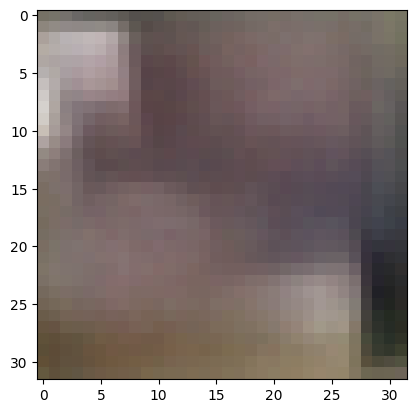

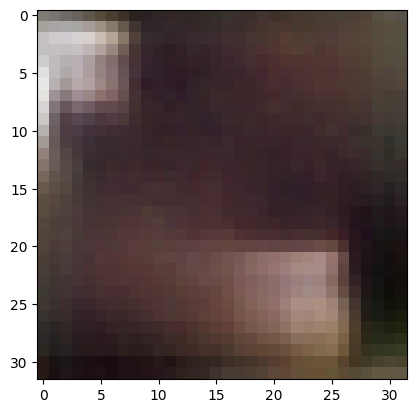

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


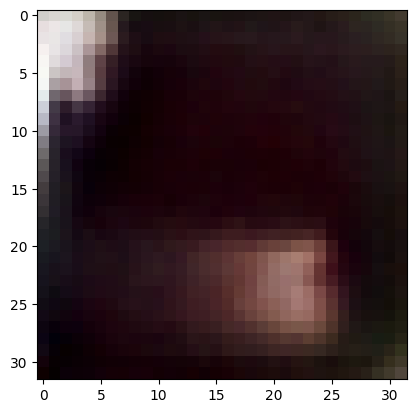

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


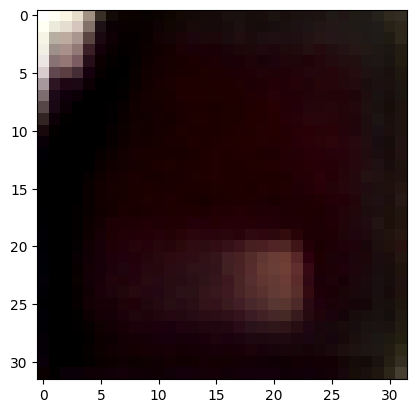

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


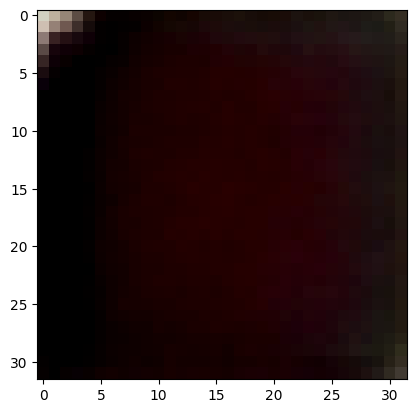

In [31]:
max_time_steps = 100

n_samples = 1
xt = torch.randn((n_samples, 3, 32, 32)).to(device)
T = max_time_steps
s = 0.008

label = torch.tensor([6], device=device)

# print(CosineNoise.get_alpha_t(T))
for _ in range(5):
    with torch.no_grad():
        for t in torch.arange(max_time_steps, 0, -1):
            t = t.expand((n_samples)).to(device)
            a_t = CosineNoise.get_alpha_t(t)
            alpha_t_barre = CosineNoise.get_alpha_t_barre(t)
            sigma = torch.sqrt(1-a_t).view(n_samples, 1, 1, 1)
            z = torch.randn_like(xt)
            # print(xt.shape)
            epsilon = net(xt, t, label)
            a = ((1 - a_t)/(torch.sqrt(1 - alpha_t_barre))).view(n_samples, 1, 1, 1)
            b = (1/torch.sqrt(a_t)).view(n_samples, 1, 1, 1)
            # print(t[0].item(), a_t[0].item(), alpha_t_barre[0].item(), sigma[0].item(), a[0].item(), b[0].item(), z.shape, epsilon.shape, sep=' | ')
            # print(xt.shape, epsilon.shape)
            
            # xt = b*(xt - a*epsilon) + sigma*z

            # xt = torch.sqrt(1- a_t).view(n_samples, 1, 1, 1) * epsilon + sigma * z
            
            xt = b * (xt - torch.sqrt(1-alpha_t_barre)*epsilon) + sigma*z
            
            # print(xt[0][0][0][0], xt[0][1][0][0], xt[0][2][0][0])
            # print(xt[0])

        show_image(xt[0])